## Monte Carlo Blackjack

In [1]:
import gym
import sys
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
for i_episode in range(5):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print("End game! Reward: ",reward)
            print('You won :)\n') if reward > 0 else print("You lose :(\n")
            break

(11, 10, False)
End game! Reward:  -1.0
You lose :(

(10, 10, False)
(13, 10, False)
(15, 10, False)
End game! Reward:  -1.0
You lose :(

(13, 9, False)
(17, 9, False)
(20, 9, False)
End game! Reward:  1.0
You won :)

(6, 5, False)
End game! Reward:  -1.0
You lose :(

(18, 9, False)
End game! Reward:  1.0
You won :)



## Part 1 : Monte Carlo Prediction

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [6]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((9, 2, False), 1, 0.0), ((14, 2, False), 1, 0.0), ((19, 2, False), 0, 1.0)]
[((19, 8, False), 0, -1.0)]
[((12, 5, False), 1, 0.0), ((15, 5, False), 0, -1.0)]


In [7]:
env?

Type:        BlackjackEnv
String form: <BlackjackEnv<Blackjack-v0>>
File:        c:\users\gusti\appdata\local\programs\python\python37\lib\site-packages\gym\envs\toy_text\blackjack.py
Docstring:  
Simple blackjack environment

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with dealer having one face up and one face down card, while
player having two face up cards. (Virtually for all Blackjack games today).

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player no

In [8]:
sys.stdout.flush?

Signature: sys.stdout.flush()
Docstring:
trigger actual zmq send

send will happen in the background thread
File:      c:\users\gusti\appdata\local\programs\python\python37\lib\site-packages\ipykernel\iostream.py
Type:      method


In [9]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays
    return_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes),end="")
            sys.stdout.flush()
        ## Todo
        ## Generate episode
        episode = generate_episode(env)
        ## obtain states, actions and reward
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        ## Iteration through episode
        for i, state in enumerate(states):
            return_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1
            Q[state][actions[i]] = return_sum[state][actions[i]] / N[state][actions[i]] 
    return Q

Episode 500000/500000.

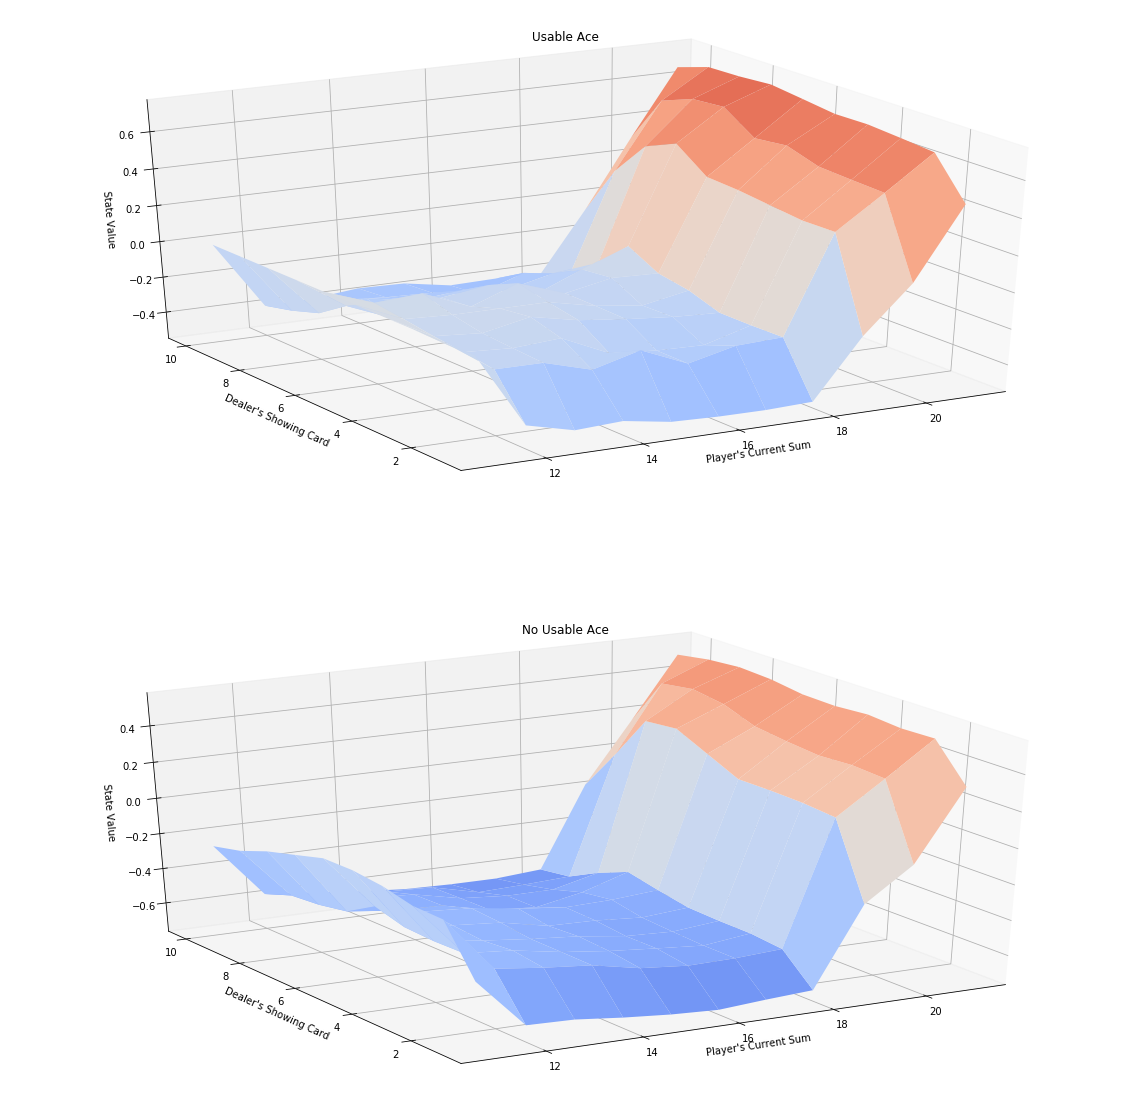

In [10]:
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) for k, v in Q.items())

plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [11]:
## Additional function
def generate_episode_from_q(env, Q, epsilon, nA):
    ## Generate episode fromm following the epsilon greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p = get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    ## obtains the action probabilities corresponding to epsilon greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon/nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    ## updates the action value function estimate using the most recent episode
    states, action, reward = zip(*episode)
    discount = np.array([gamma**i for i in range(len(reward)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][action[i]]
        Q[state][action[i]] = old_Q + alpha*(sum(reward[i:]*discount[:-(1+i)] - old_Q))
    return Q

In [12]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start = 1.0, eps_decay = .99999, eps_min = 0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        ## TODO: Complete the function
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_q(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [13]:
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

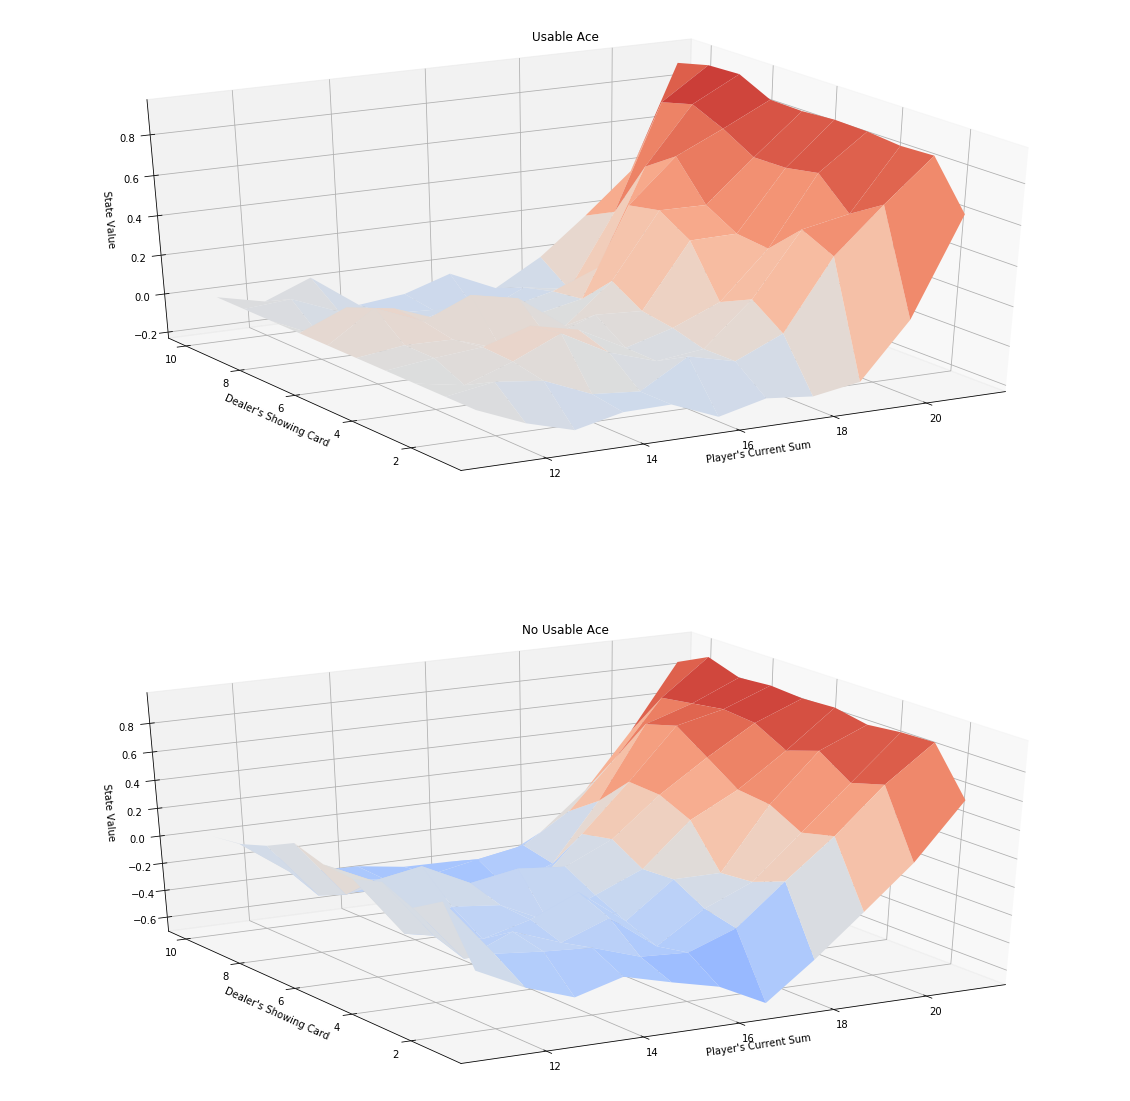

In [14]:
V = dict((k, np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)

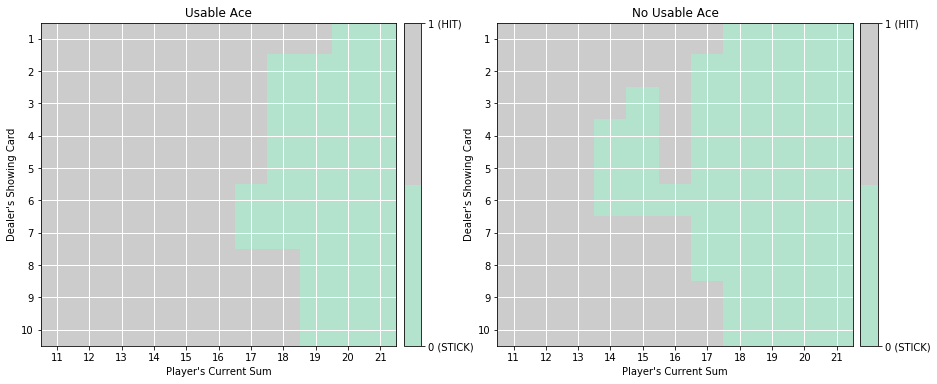

In [15]:
plot_policy(policy)

In [16]:
np.ones?

Signature: np.ones(shape, dtype=None, order='C')
Docstring:
Return a new array of given shape and type, filled with ones.

Parameters
----------
shape : int or sequence of ints
    Shape of the new array, e.g., ``(2, 3)`` or ``2``.
dtype : data-type, optional
    The desired data-type for the array, e.g., `numpy.int8`.  Default is
    `numpy.float64`.
order : {'C', 'F'}, optional, default: C
    Whether to store multi-dimensional data in row-major
    (C-style) or column-major (Fortran-style) order in
    memory.

Returns
-------
out : ndarray
    Array of ones with the given shape, dtype, and order.

See Also
--------
ones_like : Return an array of ones with shape and type of input.
empty : Return a new uninitialized array.
zeros : Return a new array setting values to zero.
full : Return a new array of given shape filled with value.


Examples
--------
>>> np.ones(5)
array([1., 1., 1., 1., 1.])

>>> np.ones((5,), dtype=int)
array([1, 1, 1, 1, 1])

>>> np.ones((2, 1))
array([[1.],
    